In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load and visualize some images

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [4]:
image_dataset = []

image_folder = '/content/drive/MyDrive/AI_For_Engineer/RestoreNoisingImage/pj2/pj2/train/data'
image_names = os.listdir(image_folder)
image_names.sort()

for image_name in image_names:
  image_path = os.path.join(image_folder, image_name)
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_dataset.append(image)


In [5]:
ground_truth = []

gt_folder = '/content/drive/MyDrive/AI_For_Engineer/RestoreNoisingImage/pj2/pj2/train/gt'
gt_names = os.listdir(gt_folder)
gt_names.sort()

for gt_name in gt_names:
  gt_path = os.path.join(gt_folder, gt_name)
  gt = cv2.imread(gt_path)
  gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
  ground_truth.append(gt)

861

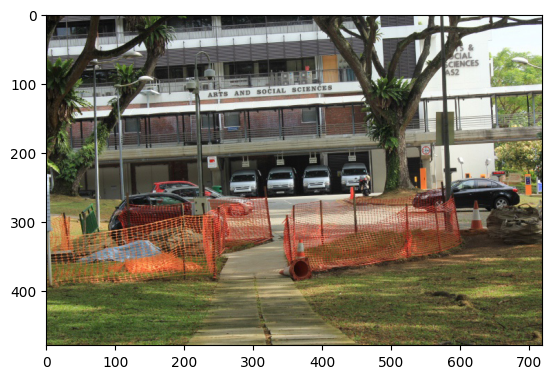

In [6]:
plt.imshow(ground_truth[0])
len(ground_truth)

In [7]:
images_labels = [[image, label] for image, label in zip(image_dataset, ground_truth)]

In [8]:
len(images_labels)

861

In [9]:
def visualize_image(image_gt):
  image = image_gt[0]
  gt = image_gt[1]
  fig, axes = plt.subplots(1, 2, figsize=(10, 10))
  for i, ax in enumerate(axes):
    ax.axis('off')
    if i == 0:
      ax.imshow(image)
      ax.set_title('Image')
    else:
      ax.imshow(gt)
      ax.set_title('Ground Truth')
  plt.show()

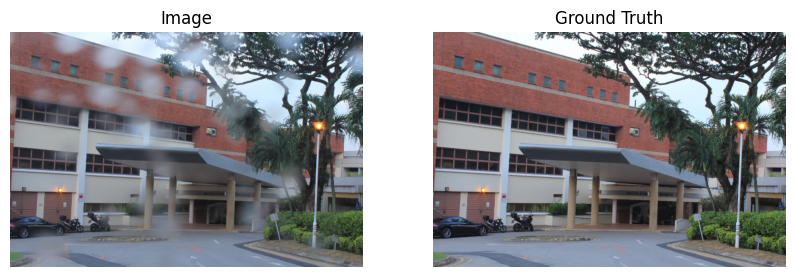

In [10]:
visualize_image(images_labels[20])

In [11]:
image = np.array(image_dataset[20]) / 255.0

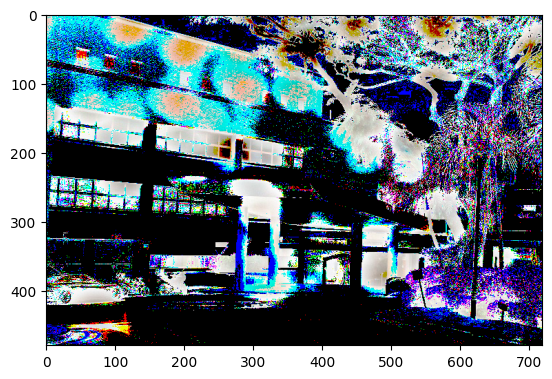

In [12]:
rain = images_labels[20][1] - images_labels[20][0]
rain = np.where(rain < 150, 0, rain)
plt.imshow(rain)

# Pre-processing images

(256, 256, 3)

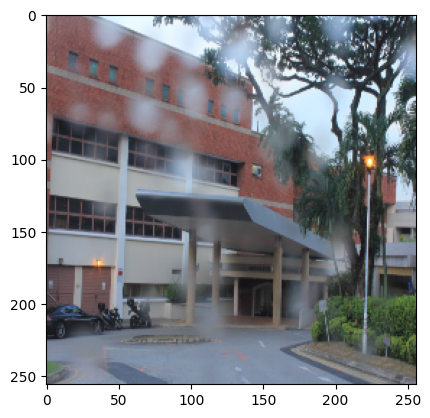

In [13]:
def preprocess_image(image):
  image = cv2.resize(image, (256, 256))
  # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  image = image.astype('float32') / 255.0
  return image

image = preprocess_image(image_dataset[20])
plt.imshow(image)
image.shape

# Pix2pix GAN

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import torchvision.utils as vutils

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [26]:
# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [27]:
# Custom Dataset
class RainDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # img_path = os.path.join(self.root_dir, 'rain', self.images[idx])
        # target_path = os.path.join(self.root_dir, 'clean', self.targets[idx])

        # img = Image.open(img_path).convert('RGB')
        # target = Image.open(target_path).convert('RGB')
        img = self.dataset[idx][0]
        target = self.dataset[idx][1]

        if self.transform:
            img = self.transform(img)
            target = self.transform(target)

        return img, target

In [52]:
# Dataset and Dataloader
dataset = RainDataset(dataset=images_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [39]:
# 1. Define Generator (UNet-like structure)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def down_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, dropout=False):
            layers = [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            if dropout:
                layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        # Encoder
        self.down1 = down_block(3, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, normalize=False)

        # Decoder
        self.up1 = up_block(512, 512, dropout=True)
        self.up2 = up_block(1024, 512, dropout=True)
        self.up3 = up_block(1024, 512, dropout=True)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))

        return self.final(torch.cat([u7, d1], 1))

# 2. Define Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def block(in_channels, out_channels, normalization=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            block(6, 64, normalization=False), # Input is [real_image, generated_image]
            block(64, 128),
            block(128, 256),
            block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Output single channel prediction
        )

    def forward(self, x):
        return self.model(x)

# 3. Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

# 4. Initialize models
gen = Generator().to(device)
disc = Discriminator().to(device)

# 5. Optimizers
optimizer_G = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 50
for epoch in range(num_epochs):
  for i, (real_A, real_B) in enumerate(dataloader):
      real_A, real_B = real_A.to(device), real_B.to(device)
      valid = torch.ones(real_A.size(0), 1, 15, 15, device=device)
      fake = torch.zeros(real_A.size(0), 1, 15, 15, device=device)

      # Train Generator
      optimizer_G.zero_grad()
      fake_B = gen(real_A)
      pred_fake = disc(torch.cat([real_A, fake_B], 1))
      loss_GAN = criterion_GAN(pred_fake, valid)
      loss_L1 = criterion_L1(fake_B, real_B) * 100
      loss_G = loss_GAN + loss_L1
      loss_G.backward()
      optimizer_G.step()

      # Train Discriminator
      optimizer_D.zero_grad()
      pred_real = disc(torch.cat([real_A, real_B], 1))
      loss_real = criterion_GAN(pred_real, valid)
      pred_fake = disc(torch.cat([real_A, fake_B.detach()], 1))
      loss_fake = criterion_GAN(pred_fake, fake)
      loss_D = (loss_real + loss_fake) / 2
      loss_D.backward()
      optimizer_D.step()

      if i % 100 == 0:
          print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

  # Save fake images for visualization
  if epoch % 10 == 0:
      fake_B = gen(real_A)
      vutils.save_image(fake_B, f'/content/drive/MyDrive/AI_For_Engineer/RestoreNoisingImage/results/fake_samples_epoch_{epoch}.png', normalize=True)

    # # Save sample generated images and model checkpoints after each epoch
    # save_image(fake_B, f"outputs/fake_samples_epoch_{epoch}.png")
    # torch.save(gen.state_dict(), f"checkpoints/gen_epoch_{epoch}.pth")
    # torch.save(disc.state_dict(), f"checkpoints/disc_epoch_{epoch}.pth")

Epoch [0/50] Batch [0/14] Loss D: 0.7178230285644531, Loss G: 61.226219177246094


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 203.06 MiB is free. Process 4270 has 14.55 GiB memory in use. Of the allocated memory 13.99 GiB is allocated by PyTorch, and 450.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)